In [34]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform
from tqdm import tqdm

In [23]:
def rdv_sequence(dat, ROI, mode='top', step=10, k_max=200, metric='correlation',
                 onset=50, resp=(50,220), base=(-50,0), random_state=0):
    rng = np.random.default_rng(random_state)
    ONSET = onset
    RESP = slice(ONSET + resp[0], ONSET + resp[1])
    BASE = slice(ONSET + base[0], ONSET + base[1])

    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == ROI]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # choose the image-set bins to calculate RDMs
    # sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    rdvs = []
    for k in sizes:
        idx = order[:k]
        Xavg = np.nanmean(X[:, :, idx], axis=0)      # (time, k)
        R = pdist(Xavg, metric=metric)   # (time, time)
        rdvs.append(R)
    return sizes, rdvs

In [96]:
DATA_DIR = '../../datasets/NNN/body_roi_data.pkl'
dat = pd.read_pickle(DATA_DIR)
print(f'Sucessfully loaded data!\nUnique ROIs: {list(dat['roi'].unique())}')

metric='correlation' # metric for RDM
step = 2 # image step after initial ramp
k_max = 400 # maximum number of images in final set
random_state = 0

Sucessfully loaded data!
Unique ROIs: ['MB1_3_B', 'MB2_20_B', 'Unknown_20_B', 'Unknown_6_B', 'MB2_21_B', 'Unknown_9_B', 'Unknown_23_B', 'MB1_8_B', 'AB3_18_B', 'MB3_12_B', 'AB3_12_B', 'AB3_17_B', 'Unknown_27_B']


In [97]:
# ROI_LIST = ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']
ROI_LIST = ['MB1_3_B', 'MB2_20_B', 'Unknown_20_B', 'Unknown_6_B', 'MB2_21_B', 'Unknown_9_B', 'Unknown_23_B', 'MB1_8_B', 'AB3_18_B', 'MB3_12_B', 'AB3_12_B', 'AB3_17_B', 'Unknown_27_B']

seqs_top, seqs_shuf = {}, {}
for roi in tqdm(ROI_LIST):
    sizes, rdvs_top = rdv_sequence(dat, roi, mode='top', step=step, k_max=k_max,
                                   metric=metric, random_state=random_state)
    _,     rdvs_shuff = rdv_sequence(dat, roi, mode='shuffle', step=step, k_max=k_max,
                                   metric=metric, random_state=random_state)
    seqs_top[roi], seqs_shuf[roi] = rdvs_top, rdvs_shuff

# global color limits for consistency
vmax = np.nanmax([np.nanmax(R) for v in (*seqs_top.values(), *seqs_shuf.values()) for R in v])
vmin = 0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [42:41<00:00, 197.06s/it]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_16491/2435107178.py:13: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax([np.nanmax(R) for v in (*seqs_top.values(), *seqs_shuf.values()) for R in v])


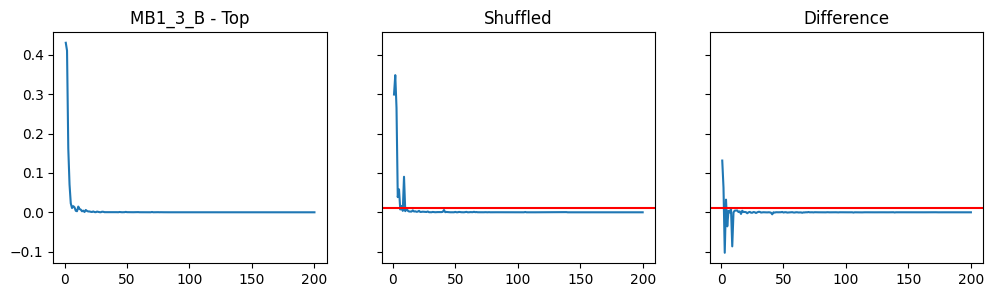

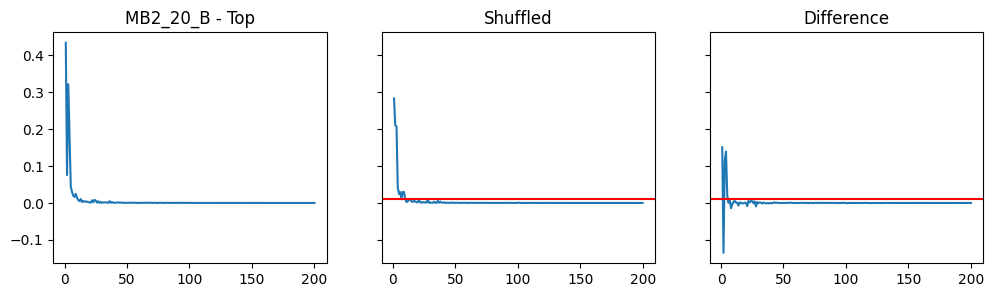

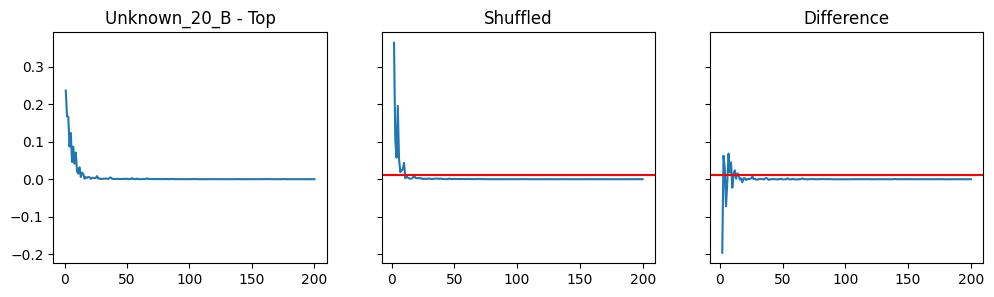

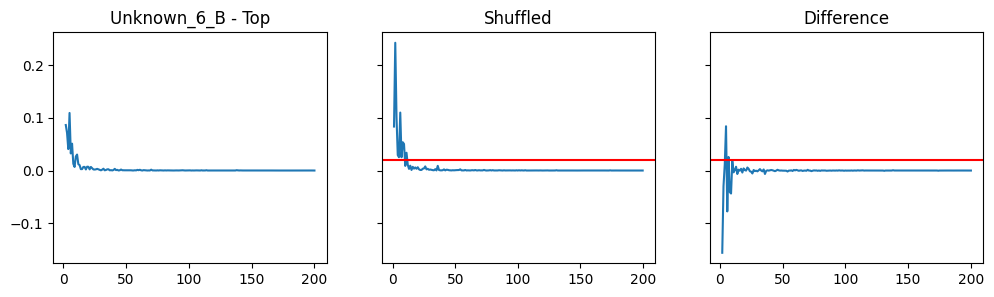

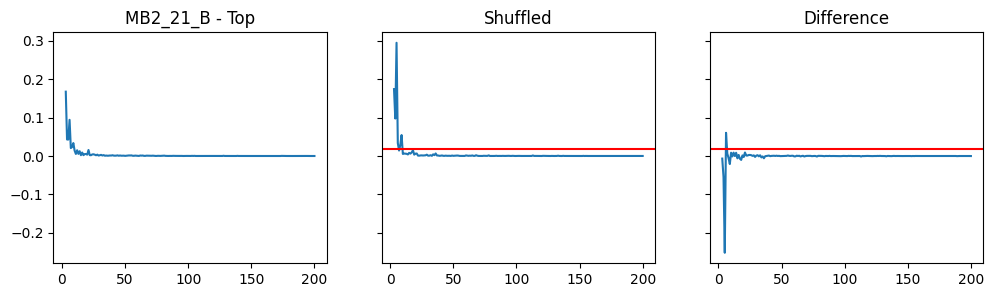

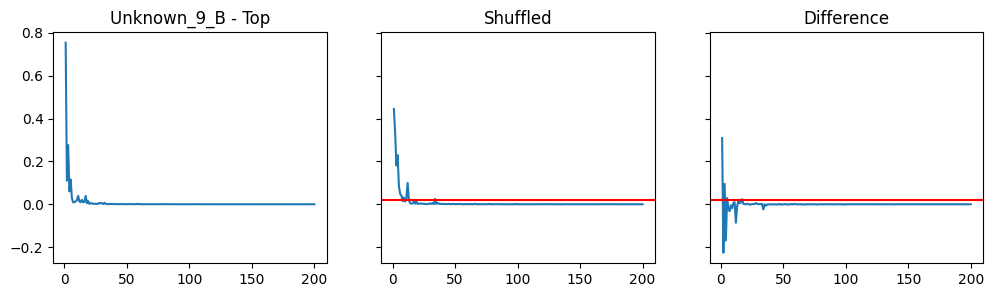

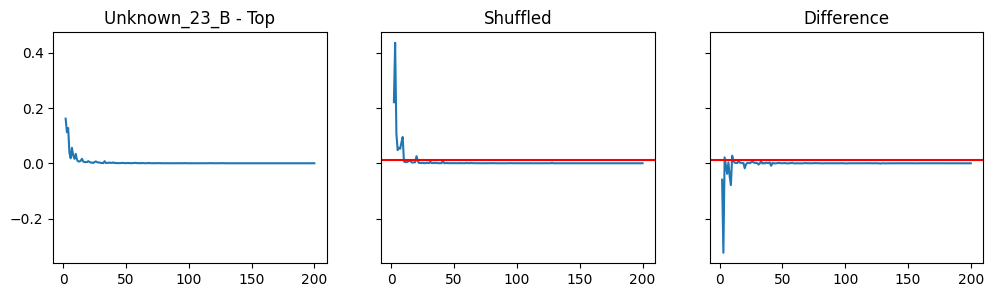

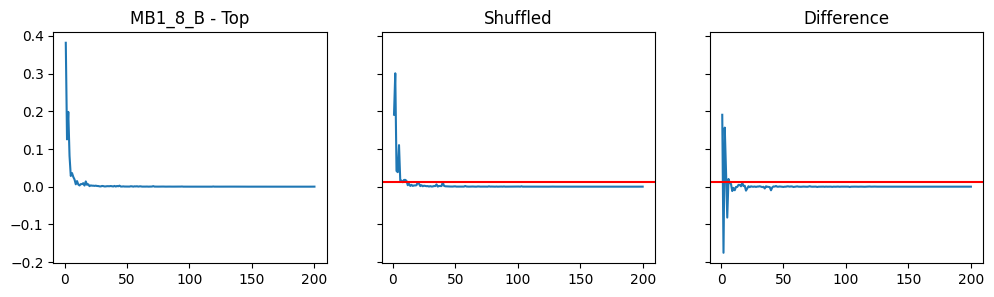

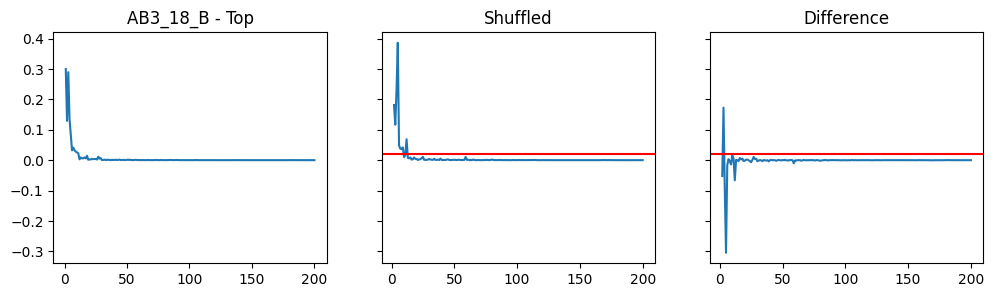

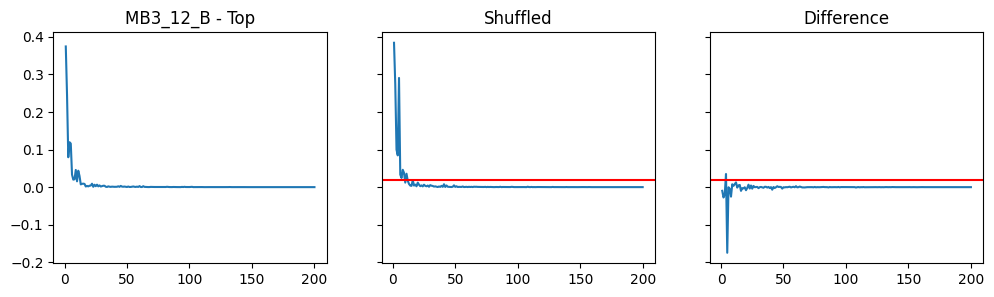

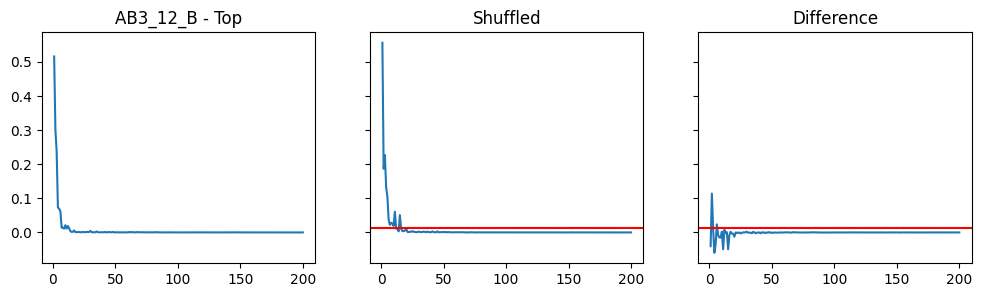

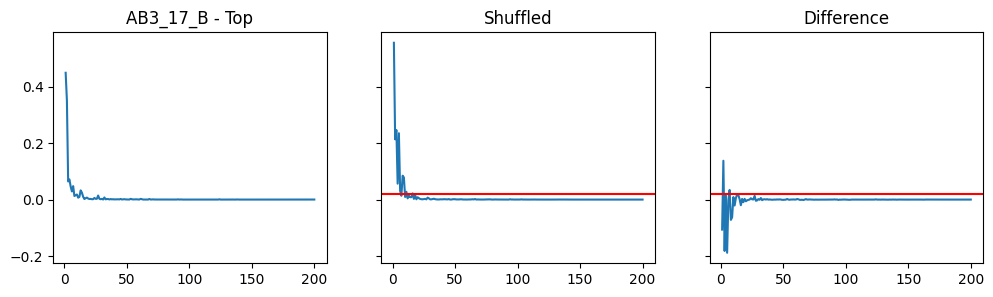

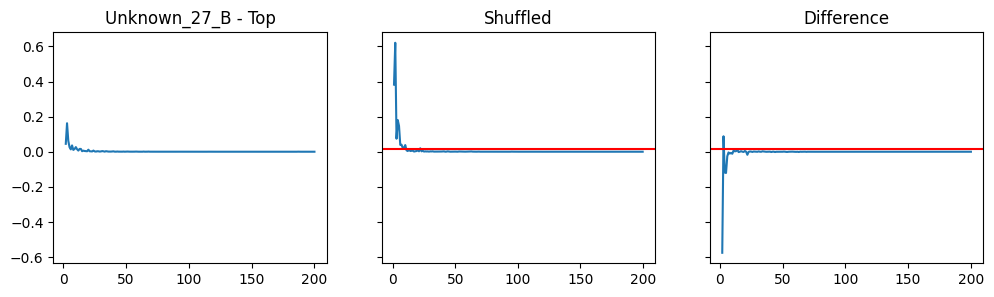

In [98]:
start = 0

for roi in ROI_LIST:
    fig, axes = plt.subplots(1,3, figsize=(12, 3), sharey=True)

    # top arrays
    t1_top = np.array(seqs_top[roi][start:-1])
    t2_top = np.array(seqs_top[roi][start+1:]); assert t1_top.shape[0] == t2_top.shape[0];
    res_top = cdist(t1_top, t2_top, metric='correlation')

    ax = axes[0]
    sns.lineplot(np.diag(res_top), ax=ax)
    ax.set_title(f'{roi} - Top')

    # shuffled arrays
    t1_top = np.array(seqs_shuf[roi][start:-1])
    t2_top = np.array(seqs_shuf[roi][start+1:]); assert t1_top.shape[0] == t2_top.shape[0];
    res_shuf = cdist(t1_top, t2_top, metric='correlation')
    
    ax = axes[1]
    sns.lineplot(np.diag(res_shuf), ax=ax)
    ax.axhline(y=np.nanmedian(res_shuf), color='red')
    ax.set_title('Shuffled')

    ax = axes[2]
    sns.lineplot(np.diag(res_top) - np.diag(res_shuf), ax=ax)
    ax.axhline(y=np.nanmedian(res_shuf), color='red')
    ax.set_title('Difference')
    plt.show()

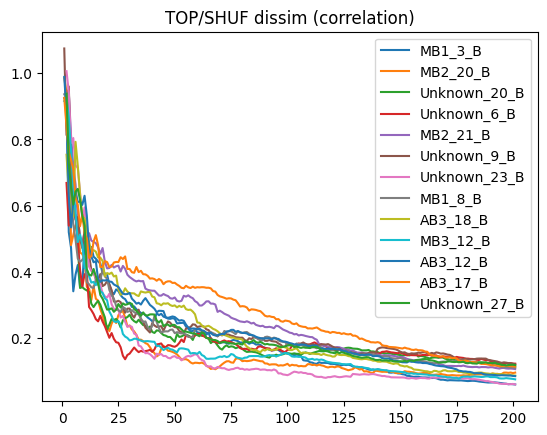

In [99]:
start = 0
met = 'correlation'

fig, ax = plt.subplots(1,1)
for roi in ROI_LIST:
    top = np.array(seqs_top[roi])
    shuf = np.array(seqs_shuf[roi])
    
    res = np.diag(cdist(top, shuf, metric=met))
    sns.lineplot(res, label=roi, ax=ax)

ax.set_title(f'TOP/SHUF dissim ({met})')
plt.show()